In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Displaying the class labels**

In [ ]:
import os

dataset_root = '/content/drive/MyDrive/dataset/train'

class_labels = os.listdir(dataset_root)

print("Class labels:",class_labels)

Class labels: ['Healthy', 'Gingivitis', 'Tooth-Discoloration', 'Mouth-Ulcer', 'Data-caries']


**Loading images and preprocessing**

In [2]:
from keras.preprocessing.image import ImageDataGenerator
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/drive/MyDrive/dataset/train", batch_size=32, target_size=(224,224),color_mode='rgb')
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/content/drive/MyDrive/dataset/test", batch_size=32, target_size=(224,224),color_mode='rgb')
vldata = ImageDataGenerator()
validatedata = vldata.flow_from_directory(directory="/content/drive/MyDrive/dataset/validation", batch_size=32, target_size=(224,224),color_mode='rgb')

Found 9019 images belonging to 5 classes.
Found 315 images belonging to 5 classes.
Found 319 images belonging to 5 classes.


**Displaying sample images of each class**

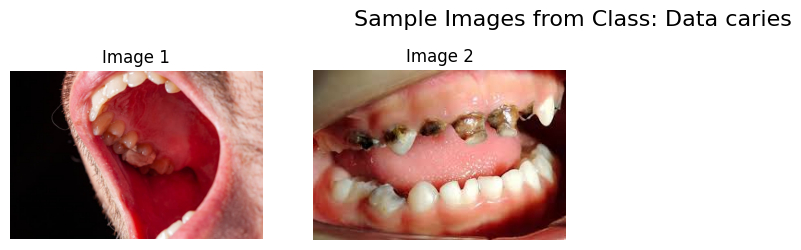

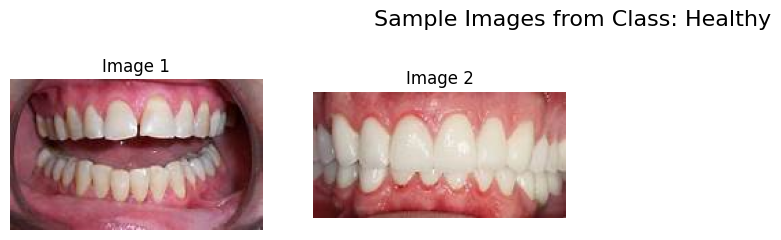

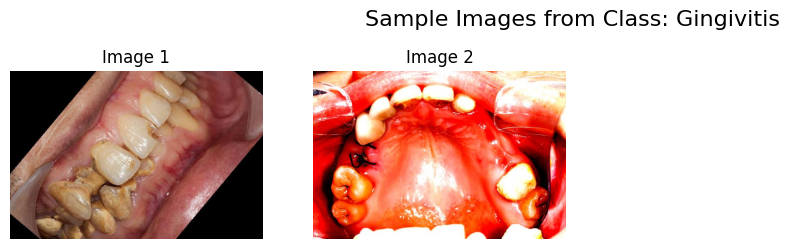

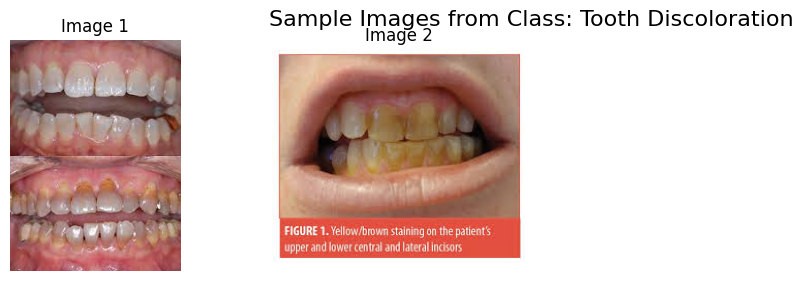

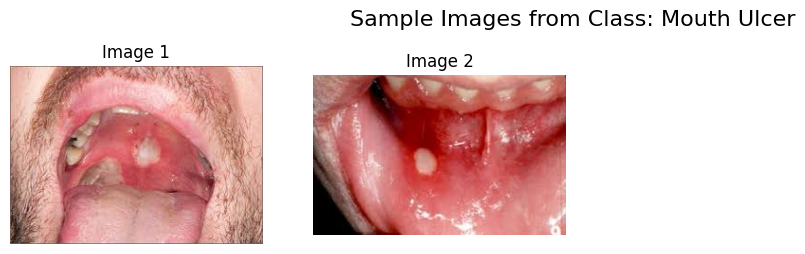

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_from_class(path, class_name):
    class_path = os.path.join(path, class_name)
    images = os.listdir(class_path)

    plt.figure(figsize=(15, 3))
    for i, image_name in enumerate(images):
        if i >= 2:
            break  # Display only the first 5 images
        img_path = os.path.join(class_path, image_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.suptitle(f"Sample Images from Class: {class_name}", fontsize=16)
    plt.show()

# Example usage:
display_images_from_class('/content/drive/MyDrive/dataset/test', 'Data caries')
display_images_from_class('/content/drive/MyDrive/dataset/test', 'Healthy')
display_images_from_class('/content/drive/MyDrive/dataset/validation', 'Gingivitis')
display_images_from_class('/content/drive/MyDrive/dataset/test', 'Tooth Discoloration')
display_images_from_class('/content/drive/MyDrive/dataset/validation', 'Mouth Ulcer')

**Displaying augmented images for each class**

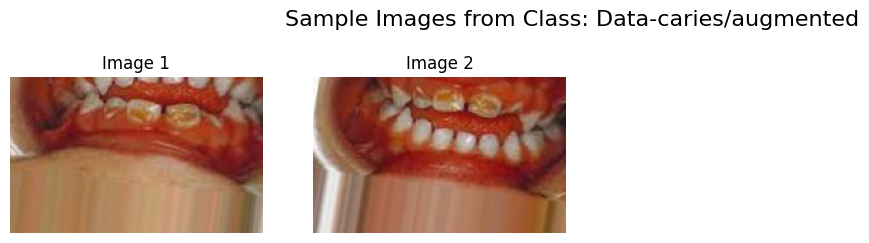

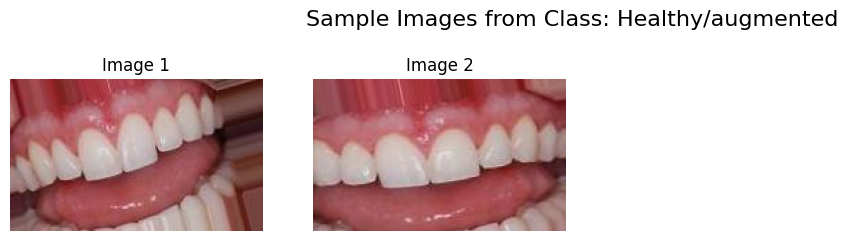

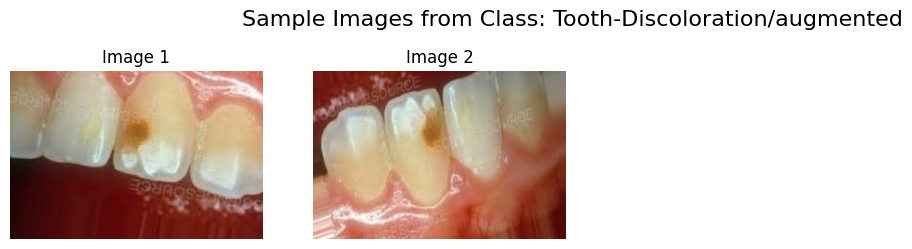

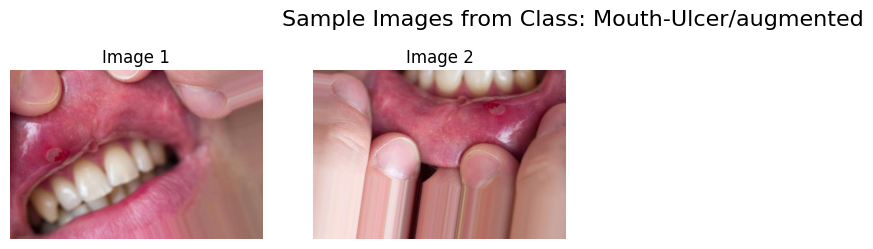

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_from_class(path, class_name):
    class_path = os.path.join(path, class_name)
    images = os.listdir(class_path)

    plt.figure(figsize=(15, 3))
    for i, image_name in enumerate(images):
        if i >= 2:
            break  # Display only the first 5 images
        img_path = os.path.join(class_path, image_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.suptitle(f"Sample Images from Class: {class_name}", fontsize=16)
    plt.show()

# Example usage:
display_images_from_class('/content/drive/MyDrive/dataset/train', 'Data-caries/augmented')
display_images_from_class('/content/drive/MyDrive/dataset/train', 'Healthy/augmented')
display_images_from_class('/content/drive/MyDrive/dataset/train', 'Tooth-Discoloration/augmented')
display_images_from_class('/content/drive/MyDrive/dataset/train', 'Mouth-Ulcer/augmented')

**Import necessary libraries**

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, metrics
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image

**preprocessing the data**

In [5]:
# Preprocess the data
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

traindata = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset/train', target_size=(224, 224), batch_size=32,color_mode='rgb')
validatedata = valid_datagen.flow_from_directory('/content/drive/MyDrive/dataset/validation', target_size=(224, 224), batch_size=32,color_mode='rgb')

Found 9019 images belonging to 5 classes.
Found 319 images belonging to 5 classes.


# **Hybrid Model**


**Model for feature extraction is EfficientNet**

In [ ]:
# Load the pre-trained EfficientNet model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
efficientnet_model.trainable = False

# Get the output tensor from the last block (block 7)
last_block_output = efficientnet_model.get_layer('block7a_project_bn').output

16705208/16705208 [==============================] - 0s 0us/step


**Model for classification is CBAM**

In [ ]:
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = tf.keras.layers.Dense(channel // ratio, activation='relu')(input_feature)
    shared_layer_two = tf.keras.layers.Dense(channel, activation='sigmoid')(shared_layer_one)
    attention = tf.keras.layers.Multiply()([input_feature, shared_layer_two])
    return attention
# Apply channel attention
channel_attention_output = channel_attention(last_block_output)
x = tf.keras.layers.GlobalAveragePooling2D()(channel_attention_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

**Compiling the model**

In [ ]:
# Create the final model
model = tf.keras.Model(efficientnet_model.input, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                       metrics.Precision(),
                       metrics.Recall(),
                       metrics.AUC()],run_eagerly=True)

In [ ]:
visualizer(model,file_name='graph',file_format=None,view=False,settings=None)

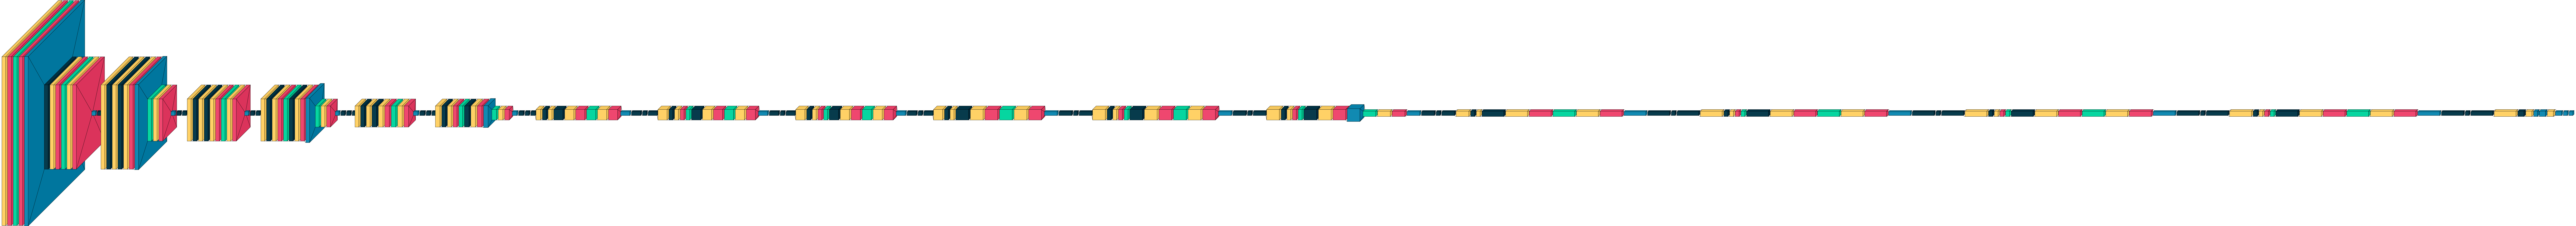

In [ ]:
import visualkeras
visualkeras.layered_view(model)

**Training the model**

In [ ]:
# Calculate steps per epoch and validation steps
steps_per_epoch = traindata.samples // traindata.batch_size
validation_steps = validatedata.samples // validatedata.batch_size

# Train the model
history = model.fit(
    traindata,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validatedata,
    validation_steps=validation_steps
)

Epoch 1/10
281/281 [==============================] - 2547s 9s/step - loss: 0.3666 - accuracy: 0.8677 - precision: 0.8981 - recall: 0.8312 - auc: 0.9830 - val_loss: 0.2667 - val_accuracy: 0.9028 - val_precision: 0.9143 - val_recall: 0.8889 - val_auc: 0.9903
Epoch 2/10
281/281 [==============================] - 1968s 7s/step - loss: 0.1727 - accuracy: 0.9409 - precision: 0.9500 - recall: 0.9320 - auc: 0.9958 - val_loss: 0.2776 - val_accuracy: 0.9167 - val_precision: 0.9196 - val_recall: 0.9132 - val_auc: 0.9854
Epoch 3/10
281/281 [==============================] - 1940s 7s/step - loss: 0.1050 - accuracy: 0.9652 - precision: 0.9692 - recall: 0.9605 - auc: 0.9983 - val_loss: 0.2688 - val_accuracy: 0.9201 - val_precision: 0.9362 - val_recall: 0.9167 - val_auc: 0.9845
Epoch 4/10
281/281 [==============================] - 1934s 7s/step - loss: 0.0766 - accuracy: 0.9747 - precision: 0.9770 - recall: 0.9725 - auc: 0.9991 - val_loss: 0.2830 - val_accuracy: 0.8924 - val_precision: 0.8920 - val_r

**Testing The Model**

In [ ]:
evaluation = model.evaluate(testdata)
print("Loss: ",evaluation[0])
print("Accuracy: ",evaluation[1])

10/10 [==============================] - 71s 7s/step - loss: 0.1606 - accuracy: 0.9460 - precision: 0.9521 - recall: 0.9460 - auc: 0.9960
Loss:  0.16055642068386078
Accuracy:  0.9460317492485046


**Train accuracy and Test accuracy**

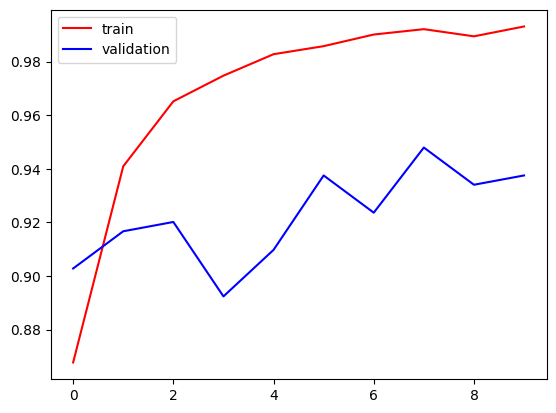

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

**Train loss and validation loss**

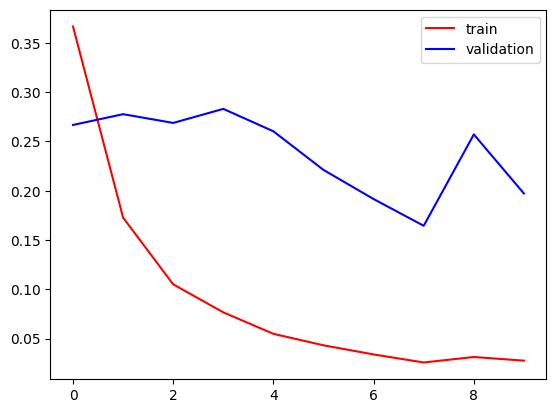

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

**Training precision and validation precision**

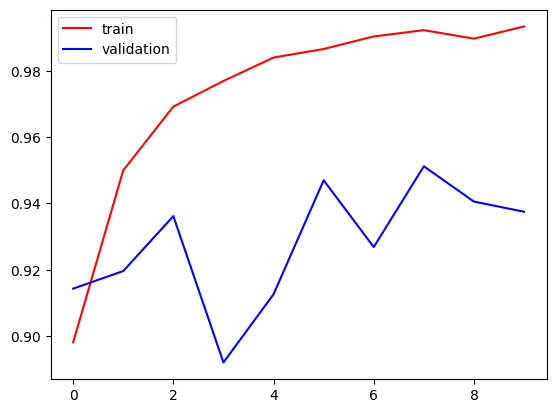

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['precision'],color='red',label='train')
plt.plot(history.history['val_precision'],color='blue',label='validation')
plt.legend()
plt.show()

**Training recall vs validation recall**

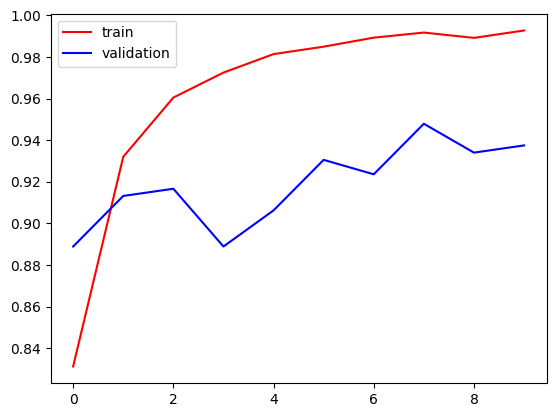

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['recall'],color='red',label='train')
plt.plot(history.history['val_recall'],color='blue',label='validation')
plt.legend()
plt.show()

**Predictions**

**Healthy predications**

1/1 [==============================] - 0s 233ms/step
Data-caries:1.8544271895848397e-06%
Gingivitis:0.0001423874095962674%
Healthy:99.9997615814209%
Mouth-Ulcer:3.940700992188795e-05%
Tooth Discoloration:6.098531457610079e-05%
Predicted class: Healthy


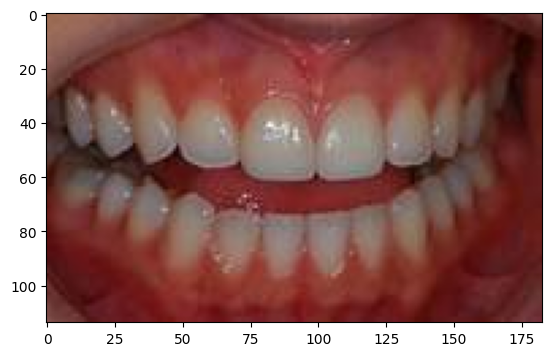

In [ ]:
class_labels = ['Data-caries', 'Gingivitis', 'Healthy', 'Mouth-Ulcer', 'Tooth Discoloration']
image_path = "/content/drive/MyDrive/dataset/train/Healthy/real/3869.jpg"  # Replace with the path to your image
image = Image.open(image_path)
plt.imshow(image)
image = image.resize((224, 224))

# Convert the image to numpy array
image = np.array(image)

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions, axis=1)

#print("Predicted class:", class_labels[predicted_class[0]])
for i,prob in enumerate(predictions[0]):
  label=class_labels[i]
  print(f"{label}:{prob*100}%")
print("Predicted class:", class_labels[predicted_class[0]])

**Mouth Ulcer predications**

1/1 [==============================] - 0s 229ms/step
Data-caries:0.0002368554532949929%
Gingivitis:0.006665166438324377%
Healthy:0.0016829180822242051%
Mouth-Ulcer:99.99057054519653%
Tooth Discoloration:0.000851035747473361%
Predicted class: Mouth-Ulcer


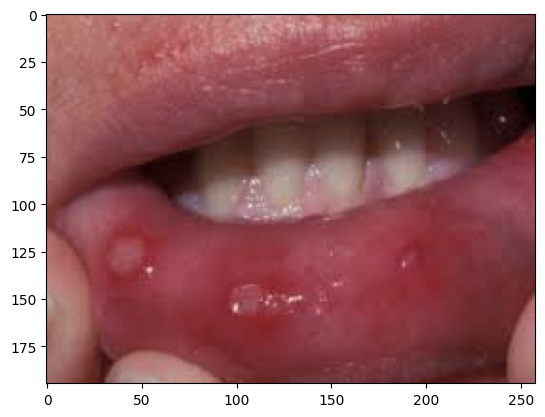

In [ ]:
class_labels = ['Data-caries', 'Gingivitis', 'Healthy', 'Mouth-Ulcer', 'Tooth Discoloration']
image_path = "/content/drive/MyDrive/dataset/test/Mouth Ulcer/5473.jpg"  # Replace with the path to your image
image = Image.open(image_path)
plt.imshow(image)
image = image.resize((224, 224))

# Convert the image to numpy array
image = np.array(image)

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions, axis=1)

#print("Predicted class:", class_labels[predicted_class[0]])
for i,prob in enumerate(predictions[0]):
  label=class_labels[i]
  print(f"{label}:{prob*100}%")
print("Predicted class:", class_labels[predicted_class[0]])

**Gingivitis predications**

1/1 [==============================] - 0s 221ms/step
Data-caries:0.07914676680229604%
Gingivitis:99.9206006526947%
Healthy:1.4682885307593097e-05%
Mouth-Ulcer:6.2971089676011616e-06%
Tooth Discoloration:0.0002305475618413766%
Predicted class: Gingivitis


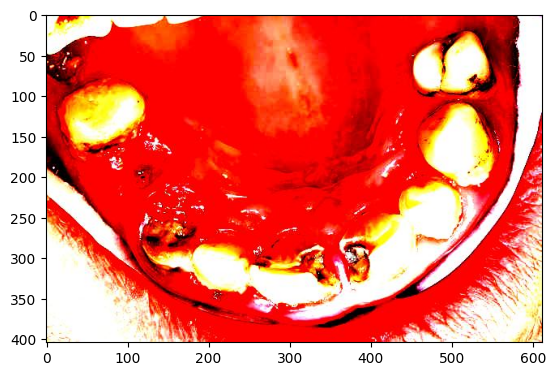

In [ ]:
class_labels = ['Data-caries', 'Gingivitis', 'Healthy', 'Mouth-Ulcer', 'Tooth Discoloration']
image_path = "/content/drive/MyDrive/dataset/validation/Gingivitis/3758.jpg"  # Replace with the path to your image
image = Image.open(image_path)
plt.imshow(image)
image = image.resize((224, 224))

# Convert the image to numpy array
image = np.array(image)

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions, axis=1)

#print("Predicted class:", class_labels[predicted_class[0]])
for i,prob in enumerate(predictions[0]):
  label=class_labels[i]
  print(f"{label}:{prob*100}%")
print("Predicted class:", class_labels[predicted_class[0]])

**Tooth Discoloration predictions**

1/1 [==============================] - 1s 538ms/step
Data-caries:0.0648391607683152%
Gingivitis:0.0015956737115629949%
Healthy:2.109255825555323e-09%
Mouth-Ulcer:1.0881303497134454e-08%
Tooth Discoloration:99.93355870246887%
Predicted class: Tooth Discoloration


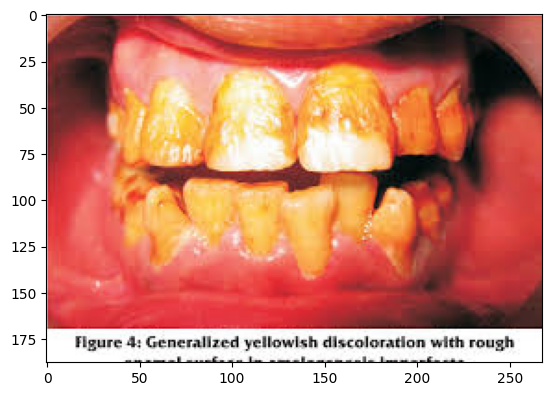

In [ ]:
class_labels = ['Data-caries', 'Gingivitis', 'Healthy', 'Mouth-Ulcer', 'Tooth Discoloration']
image_path = "/content/drive/MyDrive/dataset/train/Tooth-Discoloration/real/5737.jpg"  # Replace with the path to your image
image = Image.open(image_path)
plt.imshow(image)
image = image.resize((224, 224))

# Convert the image to numpy array
image = np.array(image)

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions, axis=1)

#print("Predicted class:", class_labels[predicted_class[0]])
for i,prob in enumerate(predictions[0]):
  label=class_labels[i]
  print(f"{label}:{prob*100}%")
print("Predicted class:", class_labels[predicted_class[0]])

**Data caries predications**

1/1 [==============================] - 0s 476ms/step
Data-caries:99.307382106781%
Gingivitis:0.5293671507388353%
Healthy:0.002891271833505016%
Mouth-Ulcer:0.14905108837410808%
Tooth Discoloration:0.011308274406474084%
Predicted class: Data-caries


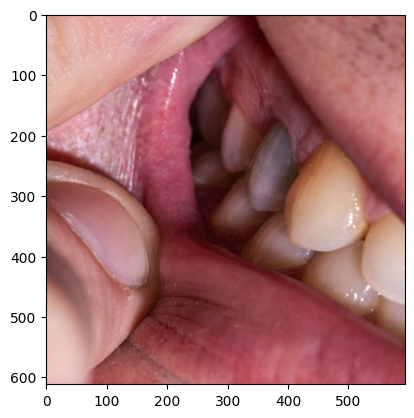

In [ ]:
class_labels = ['Data-caries', 'Gingivitis', 'Healthy', 'Mouth-Ulcer', 'Tooth Discoloration']
image_path = "/content/drive/MyDrive/dataset/validation/Data caries/1363.jpg"  # Replace with the path to your image
image = Image.open(image_path)
plt.imshow(image)
image = image.resize((224, 224))

# Convert the image to numpy array
image = np.array(image)

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions, axis=1)

#print("Predicted class:", class_labels[predicted_class[0]])
for i,prob in enumerate(predictions[0]):
  label=class_labels[i]
  print(f"{label}:{prob*100}%")
print("Predicted class:", class_labels[predicted_class[0]])

In [ ]:
model.save('hybrid_model.h5')